In [5]:
%%time
%matplotlib inline
import importlib
import new_import  
importlib.reload(new_import)
from new_import import *

CPU times: user 63.7 ms, sys: 981 µs, total: 64.7 ms
Wall time: 106 ms


In [2]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

client

Starting new cluster.
CPU times: user 595 ms, sys: 32.3 ms, total: 628 ms
Wall time: 4min 7s


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.e9759607bc6e47d985266ee3a73c2f50/status,


In [3]:
# cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0) 

coordinates = (longtitude_range, latitude_range)

In [4]:
# tải dữ liệu vh vv từ vệ tinh sentinel-1
dsvh, dsvv = load_data_sen1(dc, date_range, coordinates)

<xarray.Dataset>
Dimensions:      (time: 33, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-06T22:46:14.500000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [6]:
average_vv = calculate_average(dsvv, time_pattern='1M')
progress(average_vv)


VBox()

In [7]:
average_vh = calculate_average(dsvh, time_pattern='1M')
progress(average_vh)

VBox()

In [8]:
%%time
average_vh.compute()
average_vv.compute()

CPU times: user 8.79 s, sys: 7.03 s, total: 15.8 s
Wall time: 4min 25s


<xarray.DataArray 'vv' (time: 13, y: 8874, x: 9902)>
array([[[0.06906006, 0.07957305, 0.09409785, ..., 0.23094253,
         0.23027407, 0.23319586],
        [0.06906006, 0.07957305, 0.09409785, ..., 0.23425393,
         0.23664413, 0.2474947 ],
        [0.07378212, 0.08650854, 0.10212713, ..., 0.24990971,
         0.23486657, 0.24579485],
        ...,
        [0.07391845, 0.07370436, 0.07163539, ..., 0.04897952,
         0.04920945, 0.04933887],
        [0.07343939, 0.07252609, 0.0702525 , ..., 0.04814997,
         0.0479173 , 0.04799423],
        [0.07355063, 0.07199537, 0.06989169, ..., 0.04814997,
         0.0479173 , 0.04799423]],

       [[0.00899241, 0.00861329, 0.00829276, ..., 0.23408818,
         0.2404511 , 0.24306983],
        [0.00899241, 0.00861329, 0.00829276, ..., 0.25091022,
         0.25812387, 0.2747655 ],
        [0.00900787, 0.00860327, 0.00830202, ..., 0.2770343 ,
         0.27153593, 0.29995093],
...
        [0.06728882, 0.07021901, 0.07160655, ..., 0.04366349,
         0.04320138, 0.04254311],
        [0.07578255, 0.07568256, 0.07622363, ..., 0.04360874,
         0.0431992 , 0.04247067],
        [0.08462474, 0.08165391, 0.08174166, ..., 0.04360874,
         0.0431992 , 0.04247067]],

       [[0.10820508, 0.11146464, 0.11587781, ..., 0.23969741,
         0.23525833, 0.22797333],
        [0.10820508, 0.11146464, 0.11587781, ..., 0.25590563,
         0.25230905, 0.26266778],
        [0.11237547, 0.11584786, 0.12045314, ..., 0.28987873,
         0.26331538, 0.29312095],
        ...,
        [0.11153916, 0.13004702, 0.12090257, ..., 0.05369304,
         0.05208092, 0.04936117],
        [0.10719641, 0.11629926, 0.11002686, ..., 0.05484349,
         0.05366876, 0.05158882],
        [0.10319728, 0.10290676, 0.09967952, ..., 0.05484349,
         0.05366876, 0.05158882]]], dtype=float32)
Coordinates:
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30 2022-10-31 ... 2023-09-30
Attributes:
    units:         intensity
    nodata:        nan
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [9]:
data_sen2 = load_data_sen2(dc, date_range, coordinates)
notebook_utils.heading(notebook_utils.xarray_object_size(data_sen2))
display(data_sen2)

No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [10]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_cloud(data_sen2)
progress(result)

{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 845 ms, sys: 23.6 ms, total: 869 ms
Wall time: 866 ms


VBox()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [11]:
# calculate NDVI
dsNDVI = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = dsNDVI["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 151, y: 8874, x: 9902)>
dask.array<truediv, shape=(151, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648

In [12]:
%%time
# calculate average NDVI
average_ndvi = calculate_average(ndvi,time_pattern="1M")
progress(average_ndvi)

CPU times: user 522 ms, sys: 1.27 ms, total: 523 ms
Wall time: 520 ms


VBox()

In [13]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

In [ ]:
average_ndvi


(13, 8874, 9902)

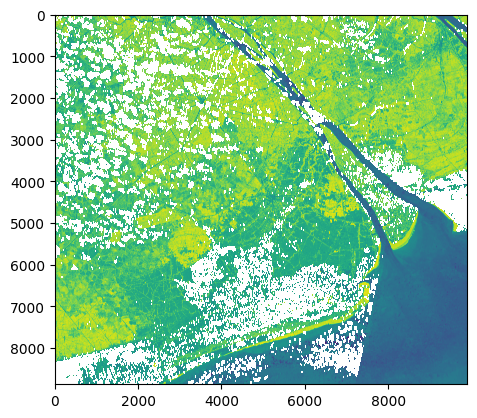

In [14]:
plt.imshow(average_ndvi.isel(time=6), vmin=None, vmax=None)
average_ndvi.shape

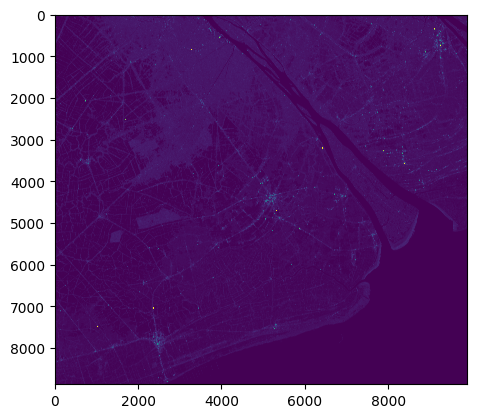

In [15]:
plt.imshow(dsvh.isel(time=6), vmin=0, vmax=1)

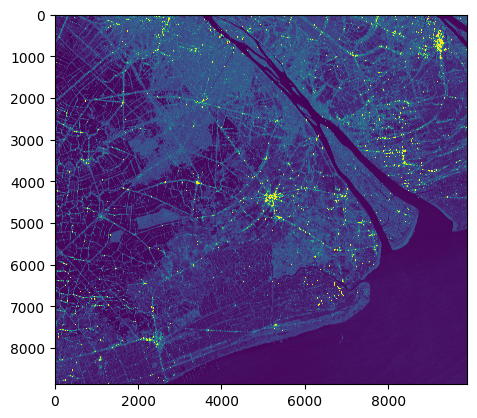

In [16]:
plt.imshow(dsvv.isel(time=6), vmin=0, vmax=1)

In [14]:
print(average_ndvi.shape, average_vv.shape, average_vh.shape)

(13, 8874, 9902) (13, 8874, 9902) (13, 8874, 9902)


In [15]:
np.savez('datasets/train_dataset/cloud_ndvi_vh_vv_10m.npz', nvdi=average_ndvi, vh=average_vh, vv=average_vv)

In [16]:
mask = ~np.isnan(average_ndvi)

X_train = np.stack([average_vh.values[mask], average_vv.values[mask]], axis=1)
y_train = average_ndvi.values[mask]

In [17]:
# Kiểm tra có giá trị NaN trong X_train
has_nan = np.isnan(X_train).any()

# In kết quả
if has_nan:
    print("Yes")
else:
    print("No.")


No.


In [23]:
X_train.shape


(754587870, 2)

DONT RUN THIS PART IF YOU DONT WANT TO TRAIN REGRESSOR MODEL

In [18]:
num_samples = 1000000

# Generate random indices
random_indices = np.random.choice(X_train.shape[0], size=num_samples, replace=False)

# Subset the data using the random indices
X_train_subset = X_train[random_indices]
y_train_subset = y_train[random_indices]

# Check the new shape
print(X_train_subset.shape)
print(y_train_subset.shape)


(1000000, 2)
(1000000,)


In [19]:
np.savez('datasets/train_dataset/1M_regressor_train.npz', X_train=X_train_subset, y_train=y_train_subset)

In [ ]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_train_subset, y_train_subset, test_size=0.2, random_state=42)

# Kiểm tra kích thước của các tập dữ liệu
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
train_set = (X_train, y_train)

In [ ]:
%%time


fill_nan_model, best_params  = cross_validate(
    train_data=(X_train, y_train), 
    model_class=regressors['random_forest'], 
    param_grid=param_grids_regressor['random_forest'], 
    metric='neg_mean_squared_error',  # Use the correct scoring for MSE
    num_fold=5
)
print(best_params)


In [21]:
folder_path = 'model_train/regressor'
file_path = os.path.join(folder_path, 'fill_nan_model_rf.pkl')
joblib.dump(fill_nan_model, file_path)


['model_train/regressor/fill_nan_model_rfr.pkl']

In [21]:
fill_nan_model = joblib.load('model_train/regressor/fill_nan_model_rf.pkl')

In [25]:
y_pred = fill_nan_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.0481191982450717


####################################################

In [16]:
fill_nan_model = joblib.load('model_train/regressor/500points/fill_nan_model_gb.pkl')

In [20]:

X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)


In [21]:
# X_pred = np.stack([average_vh.values[~mask], average_vv.values[~mask]], axis=1)
average_ndvi.values[~mask] = fill_nan_model.predict(X_pred)
average_ndvi_filled = xr.DataArray(average_ndvi, dims=average_ndvi.dims)

In [42]:
average_ndvi_filled

<xarray.DataArray 'NDVI' (time: 13, y: 8874, x: 9902)>
array([[[ 3.70842844e-01,  3.70842844e-01,  6.19868279e-01, ...,
          6.37900054e-01,  6.37840211e-01,  6.00014150e-01],
        [ 4.09747630e-01,  4.09747630e-01,  6.34832859e-01, ...,
          6.17527306e-01,  6.20078325e-01,  6.24745369e-01],
        [ 4.09747630e-01,  4.09747630e-01,  6.34832859e-01, ...,
          6.17195070e-01,  6.18910015e-01,  7.56559372e-01],
        ...,
        [ 1.72497004e-01,  4.58953112e-01,  2.66808212e-01, ...,
         -1.07296132e-01, -1.62162170e-01, -1.63636342e-01],
        [ 1.03626937e-01,  4.47405279e-01,  4.25044090e-01, ...,
         -1.84331805e-01, -1.42201796e-01, -1.60599545e-01],
        [-7.29386928e-04,  4.29869354e-01,  4.65222299e-01, ...,
         -1.11597389e-01, -1.44164741e-01, -1.15226299e-01]],

       [[-2.32006103e-01, -2.32006103e-01, -2.17974037e-01, ...,
          6.13341272e-01,  6.30607188e-01,  6.30607188e-01],
        [-2.25332618e-01, -2.25332618e-01, -2.03149900e-01, ...,
          6.80023849e-01,  6.83271587e-01,  6.83271587e-01],
        [-2.25332618e-01, -2.25332618e-01, -2.03149900e-01, ...,
          6.80023849e-01,  6.83271587e-01,  6.83271587e-01],
...
         -1.16381489e-01, -2.45650217e-01, -2.56057948e-01],
        [ 1.34953871e-01,  6.61971867e-01,  6.72875404e-01, ...,
         -1.25083700e-01, -2.16893747e-01, -1.92835450e-01],
        [ 6.93548396e-02,  5.91334820e-01,  6.62259579e-01, ...,
         -1.28072619e-01, -1.65681735e-01, -1.16094612e-01]],

       [[ 6.45346582e-01,  6.45346582e-01,  6.16828561e-01, ...,
          8.56177986e-01,  8.37543666e-01,  7.80746520e-01],
        [ 6.26065314e-01,  6.26065314e-01,  6.01952553e-01, ...,
          8.29926431e-01,  8.19785774e-01,  8.17597389e-01],
        [ 6.26065314e-01,  6.26065314e-01,  6.01952553e-01, ...,
          8.32685590e-01,  8.06613624e-01,  8.07800591e-01],
        ...,
        [ 3.88286322e-01,  6.11940384e-01,  5.17369688e-01, ...,
         -3.31825316e-02, -2.29459926e-02, -4.85436544e-02],
        [ 3.34712833e-01,  6.66666687e-01,  6.42252684e-01, ...,
         -9.60827712e-03,  2.41758358e-02,  2.19135731e-03],
        [ 2.82383412e-01,  6.62507474e-01,  6.32222235e-01, ...,
         -2.05527749e-02,  9.85917915e-03, -2.33877134e-02]]],
      dtype=float32)
Coordinates:
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
  * time         (time) datetime64[ns] 2022-09-30 2022-10-31 ... 2023-09-30

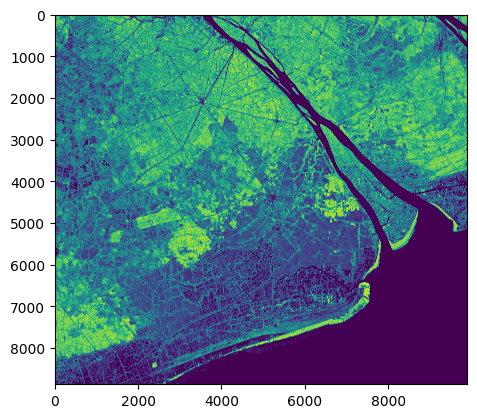

In [22]:
plt.imshow(average_ndvi_filled.isel(time=6), vmin=0, vmax=1)

In [ ]:
# Plotting actual vs predicted NDVI
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred, color='blue', alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')
plt.title('Actual vs Predicted NDVI')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
train_path = "train/ST_training data_updated_1130points.shp"
# train_path = "train/updated_data/ThuanHoa_DKS_Kappa.shp"
train = load_data_geo(train_path)
train

In [ ]:
datasets = create_dataset(train, average_ndvi_filled, average_vh, average_vv)

In [ ]:
len(datasets)
datasets

In [30]:
# cấu hình nhãn dữ liệu
label_mapping = {
    "Lua tom": "1",
    "Lua": "3",
    "CHN": "4",
    "CLN": "5",
    "TS": "6",
    "Song": "7",
    "Dat xay dung": "8",
    "Rung": "9"
}


In [35]:
X_train, X_test, y_train, y_test = split_train_data(train, label_mapping, datasets)


data length: 1130, label length: 1130
SAve dataset
X_train length: 904, y_train length: 904


In [44]:
data_train=(X_train, y_train)
model_type='svm'
best_model = find_best_model(dataset=data_train, model_type=model_type)


Using classifier: SVC
Best Parameters: {'classifier__C': 10, 'classifier__kernel': 'rbf'}


In [45]:
cross_validate(data_train, best_model, 5) 


Validation scores over splits: [0.9060773480662984, 0.9502762430939227, 0.9171270718232044, 0.9392265193370166, 0.9277777777777778, 0.9171270718232044, 0.9281767955801105, 0.9060773480662984, 0.9392265193370166, 0.95]
Accuracy validation score: 0.9281092694904849


In [46]:
# kiểm tra độ chính xác với tập test
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 92.0 %


In [47]:
# Lưu mô hình huấn luyện
save_model("classify/classify_svm.joblib", best_model)

Done!


In [ ]:
# đóng client, cluster
client.close()
cluster.close()